# CajaMar University Hack 2023

La Viña Wine Prediction

Ana Cardells


Info somelier: 
* La producción depende de muchísimas cosas: luz, humedad, tipo de suelo, variedad de la uva, modo de cultivo...
* Normalmente a finales de junio, si no hay piedra o enfermedad, la producción ya está bastante "fija".
* También está controlada por la DO. En España, el máximo de kg/ha suele ser de 12.000
* Modos de cultivo: espaldera (más rendimiento porque le toca más el sol y está más aireado, lo que evita enfermedades) y vaso (tipo arbusto, menos producción)
* Normalmente los viñedos viejos suelen ir en vaso y tener menor rendimiento
* Clima: en primavera es importante la lluvia, en mayo es muy peligrosa la piedra (destruye lo que está brotando), en verano es muy imporante el sol (y cuanta menos lluvia mejor)
* La cepa es bastante de secano
* La humedad es un foco de enfermedades. Las enfermedades son uno de los focos de pérdidas principales.
* El tipo de suelo es importante. Suelos muy pobres y con pocos nutrientes dan menos rendimiento (aunque luego la calidad puede ser alta)
* La variedad de la uva también influye. No todas producen lo mismo. 
* En las viñas no hay barbecho.


Web:
* La DO Valencia no impone un límite de producción específico para los vinos amparados bajo su denominación. En su lugar, establece una serie de normas y requisitos en cuanto a los viñedos, las variedades de uva, la elaboración del vino, el envejecimiento, etc. con el objetivo de garantizar la calidad y la autenticidad de los vinos producidos bajo su sello.

## Imports

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime

In [2]:
# import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AffinityPropagation, AgglomerativeClustering
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, silhouette_score
from sklearn.linear_model import LinearRegression, Ridge, GammaRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile, f_classif
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.tree import plot_tree

## Carga de datos TRAIN y análisis

In [3]:
file = 'UH_2023_TRAIN.txt'
df_train = pd.read_csv(file, sep="|")
df_train.head(5)

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.0,22215.0
1,14,84318,515,4,660,26,2,0,1,0.0,22215.0
2,14,85579,340,4,520,32,2,0,1,0.0,20978.0
3,14,69671,340,4,520,32,2,0,1,0.0,40722.0
4,14,14001,852,14,NaN,81,1,0,1,0.0,14126.0


In [4]:
# CAMPAÑA: Año de la campaña.
# ID_FINCA: Identificador de finca.
# ID_ZONA: Identificador de una zona con una tipología de suelo común
# ID_ESTACION: Identificador de estación meteorológica.
# ALTITUD: Altitud media de la finca sobre el nivel del mar en metros.
# VARIEDAD: Código de variedad de la uva que se cultiva en la finca.
# MODO: Código del modo de cultivo.
# TIPO: Tipo de cultivo dentro de la variedad.
# COLOR: Identificador del color de la uva.
# SUPERFICIE: Superficie en hectáreas que ocupa la finca.
# PRODUCCION: Producción en kg. Obtenida en la campaña.

### Tipos de datos y NaN

In [5]:
df_train.describe()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
count,9601.000000,9601.000000,9601.000000,9601.000000,9601.000000,9601.000000,9601.000000,9601.00000,9601.000000,8526.000000
mean,17.935840,50818.244766,498.496407,12.161337,45.487658,1.509426,0.012290,0.84335,0.697517,9209.190958
std,2.609687,29016.567919,261.430506,4.763217,23.814567,0.499937,0.110184,0.36349,1.786268,13268.812623
min,14.000000,200.000000,7.000000,0.000000,4.000000,1.000000,0.000000,0.00000,0.000000,0.718000
25%,16.000000,25104.000000,284.000000,7.000000,17.000000,1.000000,0.000000,1.00000,0.000000,1940.000000
50%,18.000000,50946.000000,464.000000,12.000000,52.000000,2.000000,0.000000,1.00000,0.000000,4620.000000
75%,20.000000,76361.000000,726.000000,16.000000,59.000000,2.000000,0.000000,1.00000,0.561900,11137.500000
max,22.000000,99793.000000,990.000000,19.000000,94.000000,2.000000,1.000000,1.00000,26.850000,177520.000000


In [7]:
# Verificar si hay valores NaN en alguna columna del DataFrame
print(df_train.isna().any())

CAMPAÑA        False
ID_FINCA       False
ID_ZONA        False
ID_ESTACION    False
ALTITUD         True
VARIEDAD       False
MODO           False
TIPO           False
COLOR          False
SUPERFICIE     False
PRODUCCION      True
dtype: bool


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601 entries, 0 to 9600
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CAMPAÑA      9601 non-null   int64  
 1   ID_FINCA     9601 non-null   int64  
 2   ID_ZONA      9601 non-null   int64  
 3   ID_ESTACION  9601 non-null   int64  
 4   ALTITUD      9547 non-null   object 
 5   VARIEDAD     9601 non-null   int64  
 6   MODO         9601 non-null   int64  
 7   TIPO         9601 non-null   int64  
 8   COLOR        9601 non-null   int64  
 9   SUPERFICIE   9601 non-null   float64
 10  PRODUCCION   8526 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 825.2+ KB


Resumen:
* Altitud tiene tipos de datos "object" y valores Nan
* Produccion tienen valores Nan (miraremos si son solo los del 2022)
* Superficie tienen valor mínimo 0. 


### ID_FINCA

In [9]:
# Comprobar de cuántas fincas hay información
df_train.ID_FINCA.nunique()

1231

In [10]:
# Verificar que hay 1.075 entradas en 2022
df_train[df_train['CAMPAÑA'] == 22].shape

(1075, 11)

In [11]:
# Contar cuantas fincas (únicas) hay en 2022
df_train[df_train['CAMPAÑA'] == 22].ID_FINCA.nunique()

825

In [12]:
# Mirar las fincas de 2022 y ver por qué hay fincas repetidas: porque son diferentes tipos de uva (VARIEDAD)
df_fincas_22 = df_train.query("CAMPAÑA == 22")
df_fincas_22_dup = df_fincas_22[df_fincas_22.duplicated(['ID_FINCA'], keep=False)]
# print(len(set(df_fincas_22_dup['ID_FINCA']))) # 155
# print(len(df_fincas_22_dup['ID_FINCA']))  # 405
# 825 - 155 + 405 = 1075
df_fincas_22_dup.head(9)


,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
8529,22,98814,919,14,650-660,32,2,0,1,3.3267,NaN
8530,22,98814,919,14,650-660,40,2,0,1,2.7724,NaN
8531,22,4024,919,14,650-660,15,2,0,1,0.6622,NaN
8532,22,4024,919,14,650-660,32,2,0,1,21.1100,NaN
8533,22,4024,919,14,650-660,87,2,0,0,11.9238,NaN
8534,22,4024,919,14,650-660,40,2,0,1,18.1746,NaN
8535,22,4024,919,14,650-660,52,2,0,1,8.0726,NaN
8536,22,4024,919,14,650-660,59,2,0,1,0.0000,NaN
8537,22,4024,919,14,650-660,81,2,0,1,13.8600,NaN


In [13]:
# ID_FINCA: Calcular número de fincas por año
años = list(range(14,23))
for año in años:
    df_fincas_anteriores = df_train.loc[df_train['CAMPAÑA'] == año, 'ID_FINCA']
    print("Entradas en el año ", año, ": ", df_fincas_anteriores.shape[0], end=" y ")
    print("Fincas en el año ", año, ": ", len(set(df_fincas_anteriores)))
    # df_train.loc[df_train['CAMPAÑA'] == año,['ID_FINCA']].nunique()


Entradas en el año  14 :  1148 y Fincas en el año  14 :  912
Entradas en el año  15 :  1116 y Fincas en el año  15 :  880
Entradas en el año  16 :  1079 y Fincas en el año  16 :  854
Entradas en el año  17 :  1017 y Fincas en el año  17 :  805
Entradas en el año  18 :  1061 y Fincas en el año  18 :  814
Entradas en el año  19 :  1055 y Fincas en el año  19 :  809
Entradas en el año  20 :  1006 y Fincas en el año  20 :  780
Entradas en el año  21 :  1044 y Fincas en el año  21 :  803
Entradas en el año  22 :  1075 y Fincas en el año  22 :  825


In [14]:
# ID_FINCA: Calcular cuantas fincas aparecen solo una vez cada año
años = list(range(14,23))
for año in años:
    s = df_train.loc[df_train['CAMPAÑA'] == año]['ID_FINCA']
    s_unique = s[s.duplicated(keep=False) == False].unique()
    print(len(s_unique))


755
721
701
656
655
633
628
646
670


Resumen:
* Hay 1231 fincas
* Las fincas no son valores unívocos, ya que a veces aparecen varias veces. Por ejemplo si en la misma finca se cultivan diferentes tipos de uvas
* Cada año hay unas 670 - 750 fincas que aparecen una única vez

### ALTITUD

Hay 54 NaN y 9547 object (texto)

In [15]:
# Convertir los valores texto a float y dejar los NaaN como NaaN
def altitud_a_num(altitud):
    if not pd.isna(altitud):
        if '-' not in altitud:
            altitud = float(altitud)
        else:
            a,b = altitud.split('-')
            altitud = (float(b)+float(a))/2
    return altitud

df_train['ALTITUD'] = df_train['ALTITUD'].apply(altitud_a_num)

In [16]:
# Comprobar que cada finca tiene un único valor de altitud (sea numérico o nan)
print(df_train.groupby('ID_FINCA')['ALTITUD'].nunique(dropna=False).min())
print(df_train.groupby('ID_FINCA')['ALTITUD'].nunique(dropna=False).max())

1
1


<Axes: >

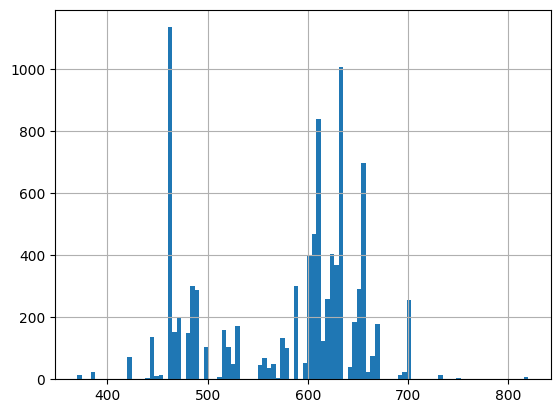

In [17]:
# Representar distribución de alturas
df_train['ALTITUD'].hist(bins=100)

In [18]:
# Tomar una decisión: qué hacer con los Nan? Reemplazar los NaN por la mediana de alturas de la estacion meteorologica
df_altitud_mediana = df_train.groupby('ID_ESTACION')['ALTITUD'].median()

# Definir una función para mapear los valores de reemplazo
def valor_reemplazo(row):
    if pd.isna(row['ALTITUD']):
        return df_altitud_mediana[row['ID_ESTACION']]
    else:
        return row['ALTITUD']

# Aplicar la función para reemplazar los NaN en "altura"
df_train['ALTITUD'] = df_train.apply(valor_reemplazo, axis=1)

In [19]:
# Guardar el archivo modificado
df_train.to_csv('UH_2023_TRAIN_alt.txt', index=False, sep='|')

Resumen:
* La mayoria de altitudes estaban definidas en un rango. Por ejemplo 650-660. Se ha sustituido por un float que es la media. En este ejemplo 655. 
* Cada finca (id_finca) tiene un único valor de altitud (sea numérico o Nan)
* Hay 15 fincas que no conocemos la altura. Además, aparecen 5 veces en el año 2022 (predicción)
* La altitud va desde 370 a 820 m, pero se tiene un pico de fincas en torno a 460 m y otro en torno a 630 m
* Se sustituyen las alturas no conocidas por la mediana de alturas de la estacion meteorológica
* Se ha grabado el archivo como UH_2023_TRAIN_alt.txt

#### PRODUCCION

In [20]:
# NaN: Analizar los valores NaN en PRODUCCION
# PRODUCCION   8526 non-null   float64
# Deben ser los de 2022
print(df_train.loc[df_train['PRODUCCION'].isna()]['CAMPAÑA'].count())
print(df_train.loc[df_train['PRODUCCION'].isna()]['CAMPAÑA'].unique())

1075
[22]


In [21]:
# Averiguar distribución de valores de producción
df_train.loc[df_train['CAMPAÑA'].isin([20,21]),['PRODUCCION']].describe()

,PRODUCCION
count,2050.000000
mean,9782.112158
std,13539.832429
min,0.718000
25%,2046.859750
50%,4812.209000
75%,11785.292250
max,130950.000000


<Axes: >

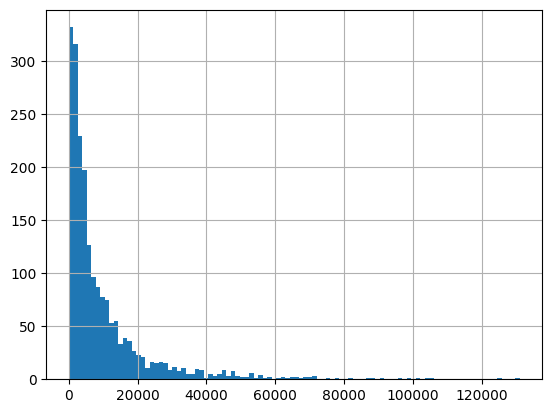

In [22]:
df_train.loc[df_train['CAMPAÑA'].isin([20,21])]['PRODUCCION'].hist(bins=100)

In [23]:
# Segun la web: 2.400 Ha. que producen anualmente 11,3 millones de kilos de uva. 
# Miramos datos anuales para comprobar que tiene sentido
for año_i in range(14,22):
    print("Produccion en la campaña", año_i, ": ", round(df_train.loc[df_train['CAMPAÑA'] == año_i]['PRODUCCION'].sum()/1e6, 2), "millones de kilos de uva")

Produccion en la campaña 14 :  9.2 millones de kilos de uva
Produccion en la campaña 15 :  10.96 millones de kilos de uva
Produccion en la campaña 16 :  10.38 millones de kilos de uva
Produccion en la campaña 17 :  7.79 millones de kilos de uva
Produccion en la campaña 18 :  10.79 millones de kilos de uva
Produccion en la campaña 19 :  9.35 millones de kilos de uva
Produccion en la campaña 20 :  9.65 millones de kilos de uva
Produccion en la campaña 21 :  10.4 millones de kilos de uva


Resumen:
* En la columna produccion hay 1075 NaN que corresponden con los valores de 2022 que hay que predecir
* La produccion anual aparentemente ha ido aumentando en los últimos años con 9.6M en 2020, 10.4M en 2021 y 11.3M en 2022 (datos de la web)
* La suma de las producciones anuales "tiene sentido"


### SUPERFICIE

In [24]:
# SUPERFICIE: Comprobar que antes del 2020 está a cero. 
años_a = list(range(14,20))
print("Años previos a 2020, datos de superficie: \n", df_train.loc[df_train['CAMPAÑA'].isin(años_a),'SUPERFICIE'].describe())

Años previos a 2020, datos de superficie: 
 count    6476.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: SUPERFICIE, dtype: float64


In [25]:
# SUPERFICIE: Comprobar si en 2020-2021-2022 sí hay datos de superficie para todas las parcelas
años_d = [20, 21, 22]
print("Años 2020 y siguientes, datos de superficie: \n", df_train.loc[df_train['CAMPAÑA'].isin(años_d),'SUPERFICIE'].describe())
print("Años 2020 y siguientes, numero de nan: \n", df_train.loc[df_train['CAMPAÑA'].isin(años_d),'SUPERFICIE'].isna().sum())

Años 2020 y siguientes, datos de superficie: 
 count    3125.000000
mean        2.142997
std         2.589688
min         0.000000
25%         0.600000
50%         1.320000
75%         2.680000
max        26.850000
Name: SUPERFICIE, dtype: float64
Años 2020 y siguientes, numero de nan: 
 0


In [26]:
# Numero de entradas con superficie 0 en 2020-2022
print("Número de filas con superficie a cero en 2020-2022: ", df_train.query('CAMPAÑA in @años_d and SUPERFICIE == 0').shape[0])

Número de filas con superficie a cero en 2020-2022:  42


In [28]:
# Analizar valores de superficie en un ejemplo de finca
finca_i = 797
df_train.query('CAMPAÑA in @años_d and ID_FINCA == @finca_i')

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
6653,20,797,845,16,647.5,68,1,0,0,2.3854,3130.0
6654,20,797,845,16,647.5,59,1,0,1,3.3577,6950.0
7672,21,797,845,16,647.5,68,1,0,0,2.3854,10180.0
7673,21,797,845,16,647.5,59,1,0,1,7.5143,11710.0
8745,22,797,845,16,647.5,68,1,0,0,2.3854,NaN
8746,22,797,845,16,647.5,59,1,0,1,7.5143,NaN


In [29]:
# Revisar que el color siempre va asociado a una variedad
df_train.groupby('VARIEDAD')['COLOR'].nunique().max()

1

In [30]:
# Revisar si el tipo siempre va asociado a una variedad (respuesta: no)
df_train.groupby('VARIEDAD')['TIPO'].nunique().max()

2

In [31]:
# Revisar si el modo siempre va asociado a una variedad (respuesta: no)
df_train.groupby('VARIEDAD')['MODO'].nunique().max()

2

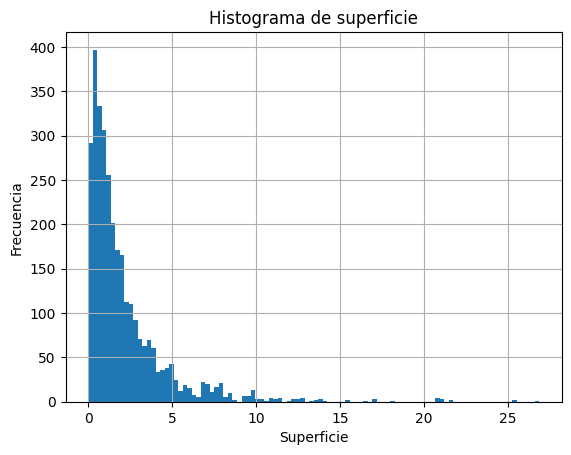

In [32]:
# Representar los tamaños de las parcelas
df_train.query('CAMPAÑA in @años_d')['SUPERFICIE'].hist(bins=100)
plt.xlabel('Superficie')
plt.ylabel('Frecuencia')
plt.title('Histograma de superficie')
plt.show()

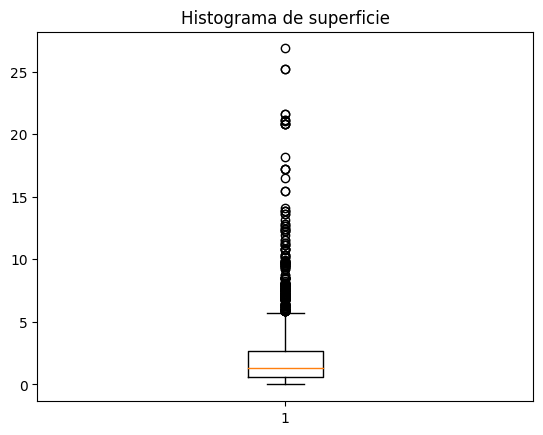

In [33]:
plt.boxplot(df_train.query('CAMPAÑA in @años_d')['SUPERFICIE'])
plt.title('Histograma de superficie')
plt.show()

In [34]:
# Segun la web: 2.400 Ha. que producen anualmente 11,3 millones de kilos de uva 
print(" La superficie total en ha en 2020 es de: ", round(df_train.query('CAMPAÑA == 20')['SUPERFICIE'].sum(),2))
print(" La superficie total en ha en 2021 es de: ", round(df_train.query('CAMPAÑA == 21')['SUPERFICIE'].sum(),2))
print(" La superficie total en ha en 2022 es de: ", round(df_train.query('CAMPAÑA == 22')['SUPERFICIE'].sum(),2))

 La superficie total en ha en 2020 es de:  2187.48
 La superficie total en ha en 2021 es de:  2224.05
 La superficie total en ha en 2022 es de:  2285.34


#### Añadir info a fincas sin superficie

In [35]:
# Calcular numero de filas sin superficie en el dataset
print('Filas dataset: ', df_train.shape[0])
print('Filas dataset con superficie a 0: ', df_train.query('SUPERFICIE == 0').shape[0])

Filas dataset:  9601
Filas dataset con superficie a 0:  6518


In [36]:
# Transformar los 0 a NaN
df_train['SUPERFICIE'] = df_train['SUPERFICIE'].replace(0, np.nan)

In [37]:
# Aquellas fincas que en 2020, 2021 y 2022 tienen la misma superficie (si es que tienen alguna)
# para la misma variedad, serviran para completar las otras 

# Crear lista con superficies "confiables"
df_superficies = df_train.query('CAMPAÑA in @años_d')[['ID_FINCA', 'VARIEDAD', 'SUPERFICIE']]
df_superficies = df_superficies.groupby(['ID_FINCA', 'VARIEDAD']).filter(lambda x: x['SUPERFICIE'].nunique() == 1)
df_superficies = df_superficies.drop_duplicates()

In [38]:
# Completar las superficies que están a cero
df_merged = pd.merge(df_train, df_superficies, on=['ID_FINCA', 'VARIEDAD'], suffixes=('', '_superficies'), how='left')
df_merged['SUPERFICIE'] = np.where(df_merged['SUPERFICIE'].isna(), df_merged['SUPERFICIE_superficies'], df_merged['SUPERFICIE'])
df_merged = df_merged.drop(['SUPERFICIE_superficies'], axis=1)

In [39]:
df_merged.query('ID_FINCA == @finca_i')

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
201,14,797,845,16,647.5,68,1,0,0,2.3854,10140.0
202,14,797,845,16,647.5,59,1,0,1,NaN,32610.0
1349,15,797,845,16,647.5,68,1,0,0,2.3854,16960.0
1350,15,797,845,16,647.5,59,1,0,1,NaN,36490.0
2469,16,797,845,16,647.5,68,1,0,0,2.3854,14690.0
2470,16,797,845,16,647.5,59,1,0,1,NaN,41240.0
3554,17,797,845,16,647.5,68,1,0,0,2.3854,11350.0
3555,17,797,845,16,647.5,59,1,0,1,NaN,25510.0
3556,17,797,845,16,647.5,59,2,0,1,NaN,8980.0
4589,18,797,845,16,647.5,68,1,0,0,2.3854,12930.0


In [56]:
df_train = df_merged.copy()

In [57]:
# Calcular numero de filas sin superficie en el dataset
print('Filas dataset: ', df_train.shape[0])
print('Filas dataset con superficie a 0: ', df_train.query('SUPERFICIE == 0').shape[0])
print('Filas dataset con superficie a NaN: ', df_train['SUPERFICIE'].isna().sum())

Filas dataset:  9672
Filas dataset con superficie a 0:  0
Filas dataset con superficie a NaN:  2554


In [58]:
# Guardar el archivo modificado
df_train.to_csv('UH_2023_TRAIN_alt_sup.txt', index=False, sep='|')

Resumen:
* Se añade valores de superficie a partir de fincas de otros años según esta estrategia: buscar aquellas fincas que en los años en que aparecen con superficie, ésta vale lo mismo siempre (para cierta variedad). 

In [62]:
df_train.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660.0,26,2,0,1,NaN,22215.0
1,14,84318,515,4,660.0,26,2,0,1,NaN,22215.0
2,14,85579,340,4,520.0,32,2,0,1,NaN,20978.0
3,14,69671,340,4,520.0,32,2,0,1,NaN,40722.0
4,14,14001,852,14,655.0,81,1,0,1,NaN,14126.0


In [61]:
# df_train['RENDIMIENTO'] = df_train['PRODUCCION'] / df_train['SUPERFICIE']
# df_train['RENDIMIENTO'].describe()

### ID_ZONA
Tipo de suelo

In [64]:
df_train[df_train['CAMPAÑA'] == 22].groupby('ID_ZONA')['ID_ZONA'].count().describe()

count    99.000000
mean     10.959596
std      11.983764
min       1.000000
25%       3.000000
50%       7.000000
75%      15.000000
max      66.000000
Name: ID_ZONA, dtype: float64

<Axes: >

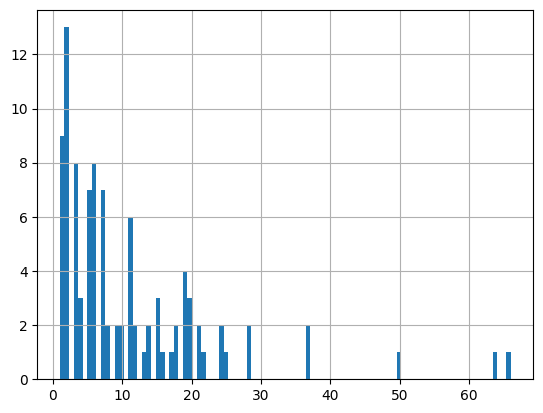

In [67]:
df_train[df_train['CAMPAÑA'] == 22].groupby('ID_ZONA')['ID_ZONA'].count().hist(bins=99)

In [68]:
# Verificar si cada finca tiene un solo tipo de suelo
df_train.groupby('ID_FINCA')['ID_ZONA'].nunique().describe()

count    1231.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: ID_ZONA, dtype: float64

Resumen (id_zona):
* Hay 125 tipos de suelo
* Cada finca tiene un único tipo de suelo

### ID_ESTACION

In [69]:
# Verificar cuantas veces aparece cada estación
df_train.groupby('ID_ESTACION')['ID_FINCA'].count()

ID_ESTACION
0        2
1        2
2       45
3      305
4        4
5     1155
6       46
7     1113
8       93
9      182
10     252
11      15
12    2060
13      16
14     621
15     956
16    1087
17       8
18     773
19     937
Name: ID_FINCA, dtype: int64

In [70]:
# Número de veces que aparece cada estación en los datos de 2022
df_train.loc[df_train['CAMPAÑA'] == 22].groupby('ID_ESTACION')['ID_FINCA'].count()

ID_ESTACION
2       5
3      39
5     122
6       5
7     135
8       7
9      31
10     26
11      3
12    201
13      2
14     91
15     90
16    121
18     93
19    114
Name: ID_FINCA, dtype: int64

In [71]:
# Entender si cada parcela tiene una única estación
df_train.groupby('ID_FINCA')['ID_ESTACION'].nunique().max()

1

In [72]:
# Visualizar un ejemplo
finca_i = 60635
df_train.loc[df_train['ID_FINCA'] == finca_i]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
302,14,60635,700,16,605.0,17,1,0,1,2.4754,22310.0
303,14,60635,700,16,605.0,17,2,0,1,2.4754,1380.0
1450,15,60635,700,16,605.0,17,1,0,1,2.4754,12740.0
2568,16,60635,700,16,605.0,17,1,0,1,2.4754,21740.0
3653,17,60635,700,16,605.0,17,1,0,1,2.4754,10660.0
4700,18,60635,700,16,605.0,17,1,0,1,2.4754,12980.0
5764,19,60635,700,16,605.0,17,1,0,1,2.4754,17180.0
6831,20,60635,700,16,605.0,17,1,0,1,2.4754,16660.0
6832,20,60635,700,16,605.0,81,2,0,1,1.1044,7090.0
7845,21,60635,700,16,605.0,17,1,0,1,2.4754,19910.0


In [73]:
# La estación da idea de proximidad de fincas? Similar altura?
estacion_i = 12
df_train.loc[df_train['ID_ESTACION'] == estacion_i, ['ID_ESTACION', 'ID_FINCA', 'ALTITUD']]

,ID_ESTACION,ID_FINCA,ALTITUD
619,12,87539,625.0
621,12,9006,625.0
622,12,75075,625.0
623,12,69180,625.0
624,12,3579,625.0
...,...,...,...
9624,12,25885,490.0
9629,12,84804,500.0
9630,12,84804,500.0
9631,12,95287,500.0


In [74]:
# La estación da idea de proximidad de fincas? Tipo de suelo?
estacion_i = 12
df_train.loc[df_train['ID_ESTACION'] == estacion_i, ['ID_ESTACION', 'ID_FINCA', 'ID_ZONA']]

,ID_ESTACION,ID_FINCA,ID_ZONA
619,12,87539,449
621,12,9006,449
622,12,75075,449
623,12,69180,449
624,12,3579,449
...,...,...,...
9624,12,25885,698
9629,12,84804,804
9630,12,84804,804
9631,12,95287,804


Resumen:
* Cada parcela está asociada a una única estación meteorológica
* Cada estacion meteorológica es usada por parcelas que están a alturas diferentes y que tienen un tipo diferente de suelo

### VARIEDAD

In [75]:
# Hay muchas variedades de uva codificadas en números entre el 4 y el 94. Veamos cuántas se cultivan en esta finca
df_variedades = df_train.groupby('VARIEDAD')['ID_FINCA'].count()
print("Cuántas veces aparece cada variedad en la base de datos train:\n", df_variedades)
print("Número de variedades de uva: ", df_variedades.count())
# print(df_variedades.sum())

Cuántas veces aparece cada variedad en la base de datos train:
 VARIEDAD
4       45
8       35
9      240
10       5
15     259
17    2167
23      74
26     150
32    1045
38       8
40     401
43      57
48       4
52     611
55      18
59    2770
62      18
65      39
68     503
71      16
81     568
84      54
87     431
92      62
94      92
Name: ID_FINCA, dtype: int64
Número de variedades de uva:  25


In [76]:
# Cuáles son las variedades que más se cultivan? Por ha
df_variedades_ha = df_train.loc[df_train['CAMPAÑA'].isin([20,21,22])].groupby('VARIEDAD')['SUPERFICIE'].sum()
df_variedades_ha.sort_values(ascending=False, inplace=True)
df_variedades_ha = df_variedades_ha.to_frame() 
df_variedades_ha['Porcentaje'] = df_variedades_ha['SUPERFICIE']/df_variedades_ha['SUPERFICIE'].sum()
df_variedades_ha['Porcentaje'].cumsum()

VARIEDAD
59    0.235783
32    0.380930
17    0.524295
52    0.595701
81    0.663844
40    0.711852
9     0.755232
15    0.796568
87    0.834873
26    0.867398
68    0.897109
94    0.923326
4     0.943121
23    0.959805
43    0.969831
8     0.976737
62    0.981831
84    0.985422
92    0.988872
65    0.991648
55    0.993954
48    0.996164
38    0.997936
71    0.999195
10    1.000000
Name: Porcentaje, dtype: float64

In [77]:
# Ha cambiado las uvas que mas se cultivan (por ha) en los ultimos años? (top 3)
df_variedades_ha = df_train.loc[df_train['CAMPAÑA'].isin([20,21,22])].groupby('VARIEDAD')['SUPERFICIE'].sum()
df_variedades_ha.sort_values(ascending=False, inplace=True)
df_variedades_ha = df_variedades_ha.to_frame() 
df_variedades_ha['Porcentaje'] = df_variedades_ha['SUPERFICIE']/df_variedades_ha['SUPERFICIE'].sum()
df_variedades_ha['Porcentaje'].cumsum()


VARIEDAD
59    0.235783
32    0.380930
17    0.524295
52    0.595701
81    0.663844
40    0.711852
9     0.755232
15    0.796568
87    0.834873
26    0.867398
68    0.897109
94    0.923326
4     0.943121
23    0.959805
43    0.969831
8     0.976737
62    0.981831
84    0.985422
92    0.988872
65    0.991648
55    0.993954
48    0.996164
38    0.997936
71    0.999195
10    1.000000
Name: Porcentaje, dtype: float64

In [78]:
# Cuáles son las variedades que más se cultivan? Por produccion
for año_i in range(20,22):
    df_variedades_prod = df_train.loc[df_train['CAMPAÑA'] == año_i].groupby('VARIEDAD')['PRODUCCION'].sum()
    df_variedades_prod.sort_values(ascending=False, inplace=True)
    df_variedades_prod = df_variedades_prod.to_frame() 
    df_variedades_prod['Porcentaje'] = df_variedades_prod['PRODUCCION']/df_variedades_prod['PRODUCCION'].sum()
    print("Las variedades que más se cultivan por ha en el año ", año_i	,\
          "son: ", df_variedades_prod.iloc[0:3].index.values.tolist())
    print(df_variedades_prod.iloc[0:3])

Las variedades que más se cultivan por ha en el año  20 son:  [32, 59, 17]
            PRODUCCION  Porcentaje
VARIEDAD                          
32        1.811545e+06    0.186913
59        1.755640e+06    0.181145
17        1.234820e+06    0.127407
Las variedades que más se cultivan por ha en el año  21 son:  [59, 32, 17]
            PRODUCCION  Porcentaje
VARIEDAD                          
59        2.057070e+06    0.196919
32        1.735439e+06    0.166130
17        1.327676e+06    0.127096


In [79]:
# Una variedad está asociada a un tipo de suelo (ID_ZONA)? No
df_train.groupby('VARIEDAD')['ID_ZONA'].nunique()

VARIEDAD
4      2
8      5
9     29
10     1
15    24
17    73
23    13
26    14
32    51
38     3
40    31
43     8
48     1
52    36
55     3
59    86
62     1
65     7
68    34
71     1
81    43
84     5
87    40
92     9
94    20
Name: ID_ZONA, dtype: int64

In [80]:
df_train[df_train['VARIEDAD'] == 32]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
2,14,85579,340,4,520.0,32,2,0,1,NaN,20978.0
3,14,69671,340,4,520.0,32,2,0,1,NaN,40722.0
13,14,98814,919,14,655.0,32,2,0,1,NaN,31496.5
15,14,4024,919,14,655.0,32,2,0,1,NaN,54893.9
21,14,73332,919,3,655.0,32,2,0,1,NaN,3599.6
...,...,...,...,...,...,...,...,...,...,...,...
9646,22,9944,301,10,485.0,32,2,0,1,0.900,NaN
9663,22,84174,473,10,465.0,32,2,0,1,2.628,NaN
9665,22,61478,831,10,460.0,32,2,0,1,2.490,NaN
9666,22,34244,831,10,460.0,32,2,0,1,5.190,NaN


In [81]:
# Una variedad está asociada a un modo de cultivo?
df_train.groupby('VARIEDAD')['MODO'].nunique()

VARIEDAD
4     1
8     2
9     2
10    1
15    2
17    2
23    2
26    2
32    2
38    1
40    2
43    2
48    2
52    2
55    2
59    2
62    1
65    2
68    2
71    1
81    2
84    2
87    2
92    1
94    2
Name: MODO, dtype: int64

In [82]:
# Una variedad está asociada a un tipo de cultivo? No
df_train.groupby('VARIEDAD')['TIPO'].nunique()

VARIEDAD
4     1
8     1
9     1
10    1
15    2
17    2
23    1
26    2
32    1
38    2
40    1
43    1
48    1
52    2
55    1
59    2
62    1
65    1
68    1
71    1
81    2
84    1
87    1
92    1
94    1
Name: TIPO, dtype: int64

In [83]:
# Una variedad está asociada a un color? Si
df_train.groupby('VARIEDAD')['COLOR'].nunique().max()

1

Resumen:
* Se cultivan un total de 25 variedades de uva
* El 95% de la superficie cultivada en los años 20-22 lo acumulan 14 uvas
        $$
        59,         17,        32,        52,        81,              40,        9,        15,        87,        26,         68,         94,         4,         23, 
        $$
* El 95% de la produccion obtenida en los años 20-21 lo acumulan 14 uvas
        $$
        59,        32,        17,        52,        81,        40,        87,        15,        26,        9,        94,        68,        23,        8
        $$
* Cada uva (variedad) se cultiva en parcelas a distintas alturas y distintos suelos
* Cada variedad puede tener los dos MODOS de cultivo
* La mayoría de las variedades solo tiene un TIPO de cultivo, pero hay 7 que tienen los dos
* Cada variedad solo tiene un COLOR

### MODO

Web:
Existen dos modos de cultivo de uvas: el cultivo en espaldera y el cultivo en vaso. 

El **cultivo en espaldera** implica entrenar las vides en un sistema de alambres y postes para que crezcan en una forma específica, lo que permite un mejor control del crecimiento y una mayor exposición al sol. 

El **cultivo en vaso**, por otro lado, implica dejar que las vides crezcan naturalmente en un sistema de ramas y troncos sin un sistema de soporte estructural.

In [84]:
# Hay dos modos de cultivo. Ver como se distribuyen en el dataset
df_train.groupby('MODO')['MODO'].count()

MODO
1    4710
2    4962
Name: MODO, dtype: int64

In [85]:
# Ver cómo se distribuyen los dos modos de cultivo por produccion y por años
modo_1 = []
modo_2 = []
modo_1_porcentaje = []

for año_i in range(14,22):
    m1 = df_train[df_train['CAMPAÑA'] == año_i].groupby('MODO')['PRODUCCION'].sum().iloc[0]
    m2 = df_train[df_train['CAMPAÑA'] == año_i].groupby('MODO')['PRODUCCION'].sum().iloc[1]
    modo_1.append(m1)
    modo_2.append(m2)
    modo_1_porcentaje.append(round(m1/(m1+m2),2))

print("Porcentajes de la producción realizadas con modo 1:", modo_1_porcentaje)

Porcentajes de la producción realizadas con modo 1: [0.47, 0.35, 0.38, 0.31, 0.3, 0.3, 0.19, 0.2]


In [86]:
# Verificar si el modo de cultivo depende de la uva
df_train.loc[df_train['CAMPAÑA'] == 22].groupby('MODO')['ID_FINCA'].count()

for i in range(14,23):
    print("En el año ", i, "el modo 1 se usó en ", df_train.loc[(df_train['CAMPAÑA'] == 22) & (df_train['MODO'] == 1)]['VARIEDAD'].nunique(), " uvas", end = "")
    print(" y el modo 2 se usó en ", df_train.loc[(df_train['CAMPAÑA'] == 22) & (df_train['MODO'] == 2)]['VARIEDAD'].nunique(), " uvas")

En el año  14 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  15 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  16 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  17 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  18 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  19 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  20 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  21 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas
En el año  22 el modo 1 se usó en  14  uvas y el modo 2 se usó en  23  uvas


Resumen
* Se ha ido disminuyendo el modo de cultivo tipo 1 gradualmente hasta llegar a representar un 21% de la produccion en 2022.
* El modo 1 solo se usa en 14 uvas mientras que el modo 2 se usó en 23 uvas (de las 25 que existen)

### TIPO

En cuanto al tipo de cultivo, hay dos tipos principales de uvas: uvas de vino y uvas de mesa. 

Las **uvas de vino** (0) son cultivadas para producir vino y tienen una piel más gruesa y un sabor más ácido. Dentro de cada tipo, hay muchas variedades diferentes de uvas, cada una con sus propias características únicas.

Las **uvas de mesa** (1) son cultivadas principalmente para consumo fresco y se caracterizan por tener una piel delgada y jugosa, y un sabor dulce. 

In [87]:
# Hay dos TIPOS de cultivo. Ver como se distribuyen en el dataset
df_train.groupby('TIPO').count()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,COLOR,SUPERFICIE,PRODUCCION
TIPO,,,,,,,,,,
0,9554,9554,9554,9554,9554,9554,9554,9554,7040,8485
1,118,118,118,118,118,118,118,118,78,102


In [88]:
# Distribucion por numero de entradas
tipo_0 = []
tipo_1 = []
tipo_0_porcentaje = []

for año_i in range(14,23):
    t0 = df_train[df_train['CAMPAÑA'] == año_i].groupby('TIPO')['CAMPAÑA'].count().iloc[0]

    if len(df_train[df_train['CAMPAÑA'] == año_i].groupby('TIPO')['CAMPAÑA'].count()) == 2:
        t1 = df_train[df_train['CAMPAÑA'] == año_i].groupby('TIPO')['CAMPAÑA'].count().iloc[1]
    else:
        t1 = 0
    
    tipo_0.append(t0)
    tipo_1.append(t1)
    tipo_0_porcentaje.append(round(t0/(t0+t1),2))

tipo_0_porcentaje

[1.0, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]

In [89]:
# Ver cuantas ha hay en 2022 de tipo de mesa
m2_mesa = df_train.loc[(df_train['CAMPAÑA'] == 22) & (df_train['TIPO'] == 1)]['SUPERFICIE'].sum()
m2_vino = df_train.loc[(df_train['CAMPAÑA'] == 22) & (df_train['TIPO'] == 0)]['SUPERFICIE'].sum()

print("Porcentaje de ha destinados a uva de mesa en 2022: ", round((m2_mesa/(m2_mesa+m2_vino)),2))

Porcentaje de ha destinados a uva de mesa en 2022:  0.03


In [90]:
# Comparar ha y produccion
m2_mesa = df_train.loc[(df_train['CAMPAÑA'] == 21) & (df_train['TIPO'] == 1)]['SUPERFICIE'].sum()
m2_vino = df_train.loc[(df_train['CAMPAÑA'] == 21) & (df_train['TIPO'] == 0)]['SUPERFICIE'].sum()

print("Porcentaje de ha destinados a uva de mesa en 2021: ", round((m2_mesa/(m2_mesa+m2_vino))*100,2))

m2_mesa = df_train.loc[(df_train['CAMPAÑA'] == 21) & (df_train['TIPO'] == 1)]['PRODUCCION'].sum()
m2_vino = df_train.loc[(df_train['CAMPAÑA'] == 21) & (df_train['TIPO'] == 0)]['PRODUCCION'].sum()

print("Porcentaje de la producción destinados a uva de mesa en 2021: ", round((m2_mesa/(m2_mesa+m2_vino))*100,2))

Porcentaje de ha destinados a uva de mesa en 2021:  3.16
Porcentaje de la producción destinados a uva de mesa en 2021:  1.38


In [91]:
# Qué tipo de uva suele ser de mesa?
df_train[df_train['TIPO']==1].groupby('VARIEDAD')['VARIEDAD'].count().sort_values(ascending=False)

VARIEDAD
4     45
52    28
59    15
81    13
26     7
15     6
17     2
38     2
Name: VARIEDAD, dtype: int64

Resumen:
* Entre el 98 y el 100% de la producción va destinado a tipo 0 (vino)
* En 2022, un 97% de la superficie se dedicó a uva de vino
* En 2021 un 3.19% de la superficie se dedicó a uva de mesa pero solo un 1.38% de la produccion se decicó a uva de mesa
* Solo algunas variedades serán uva de mesa (las 4 mas importantes):
    $$
    4, 52, 59, 81
    $$

### COLOR

In [92]:
# Ver la distribucion de uvas por color

for año_i in range(14,22):
    c0 = df_train.loc[(df_train['CAMPAÑA'] == año_i) & (df_train['COLOR'] == 0)]['PRODUCCION'].sum()
    c1 = df_train.loc[(df_train['CAMPAÑA'] == año_i) & (df_train['COLOR'] == 1)]['PRODUCCION'].sum()
    print("Porcentaje de la producción del año ", año_i, " destinado a uva de color 1: ", round((c1/(c1 + c0))*100,2))

Porcentaje de la producción del año  14  destinado a uva de color 1:  89.42
Porcentaje de la producción del año  15  destinado a uva de color 1:  89.06
Porcentaje de la producción del año  16  destinado a uva de color 1:  90.09
Porcentaje de la producción del año  17  destinado a uva de color 1:  87.66
Porcentaje de la producción del año  18  destinado a uva de color 1:  87.38
Porcentaje de la producción del año  19  destinado a uva de color 1:  86.5
Porcentaje de la producción del año  20  destinado a uva de color 1:  84.45
Porcentaje de la producción del año  21  destinado a uva de color 1:  81.61


Resumen:
* Como ya se dijo, cada variedad tienen un unico color
* Se cultiva más uva de color 1
* Aún así, el porcentaje de uva de color 1 ha ido descendiendo en los último 3 años

### Visualizacion 

Visualizar los datos para  buscar patrones

#### SUPERFICIE Y PRODUCCION

In [94]:
# Correlacion entre tamaño de parcela y produccion? años 2020 - 2021
df_train_mod = df_train.loc[df_train['CAMPAÑA'].isin([20,21])].copy(deep=True)
df_train_mod = df_train_mod.dropna(subset=['SUPERFICIE'])
df_train_mod.head(3)

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
6525,20,48626,302,13,600.0,32,2,0,1,3.7503,19511.107
6526,20,47921,302,13,600.0,32,2,0,1,7.3735,38678.893
6527,20,5696,919,14,655.0,59,1,0,1,7.6200,7092.800


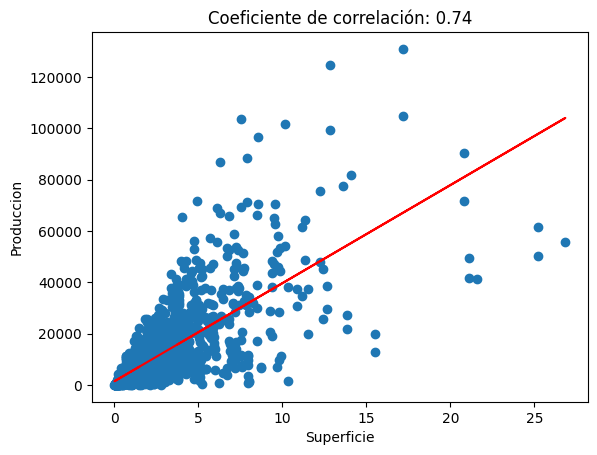

In [95]:
# Buscar relacion entre superficie y produccion
x = df_train_mod['SUPERFICIE']
y = df_train_mod['PRODUCCION']


r = np.corrcoef(x, y)[0, 1]
m, b = np.polyfit(x, y, 1)
regression_line = m * x + b

plt.scatter(x, y)
plt.plot(x, regression_line, color='red')
plt.title(f'Coeficiente de correlación: {r:.2f}')
plt.xlabel('Superficie')
plt.ylabel('Produccion')
plt.show()


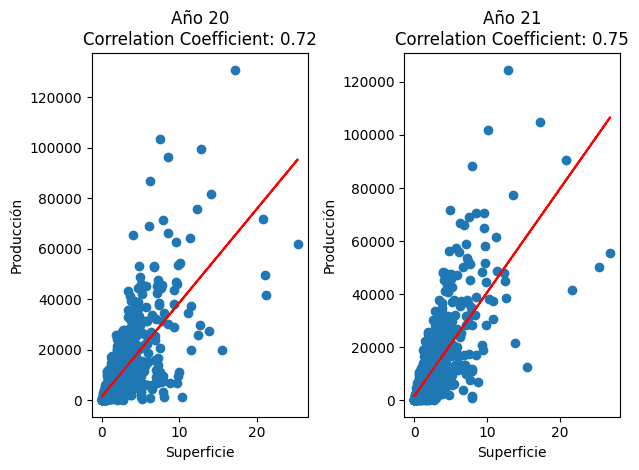

In [96]:
# Buscar relacion entre superficie y produccion por año (minimizar el efecto clima, suponiendo que no sea tan distinto entre parcelas)

for i in range(2):
    año_i = 20 + i
    x = df_train_mod.loc[df_train_mod['CAMPAÑA'] == año_i]['SUPERFICIE']
    y = df_train_mod.loc[df_train_mod['CAMPAÑA'] == año_i]['PRODUCCION']
     
    r = np.corrcoef(x, y)[0, 1]
    m, b = np.polyfit(x, y, 1)
    regression_line = m * x + b

    # graficar datos y regresión lineal
    plt.subplot(1, 2, i+1)
    plt.scatter(x, y)
    plt.plot(x, regression_line, color='red')
    plt.title(f'Año {año_i}\nCorrelation Coefficient: {r:.2f}')
    plt.xlabel('Superficie')
    plt.ylabel('Producción')

# mostrar gráficas resultantes
plt.tight_layout()
plt.show()

No encuentro patrones claros entre superficie y produccion. Esto seguramente es porque hay más variables endógenas (variedad, id_zona...) y exógenas (clima).


#### VARIEDAD Y PRODUCCION POR ha

In [97]:
# Entender si hay uvas que dan mas produccion que otras por si vale la pena clusterizar por tipo de uva: crear boxplots
df_train_mod['Kgxha'] = df_train_mod['PRODUCCION']/df_train_mod['SUPERFICIE']
df_train_mod['Kgxha'].describe()

count      2029.000000
mean       4661.234780
std        3842.519648
min           7.216080
25%        2349.129155
50%        4155.089311
75%        6320.712023
max      115879.166667
Name: Kgxha, dtype: float64

In [99]:
# Ver qué casos tienen una produccion superior a 20.000kg/ha
df_train_mod[df_train_mod['Kgxha'] > 20000]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,Kgxha
7141,20,3579,449,12,625.0,32,2,0,1,0.00072,83.433,115879.166667
7592,21,13802,464,3,655.0,59,2,0,1,0.20670,4440.000,21480.406386


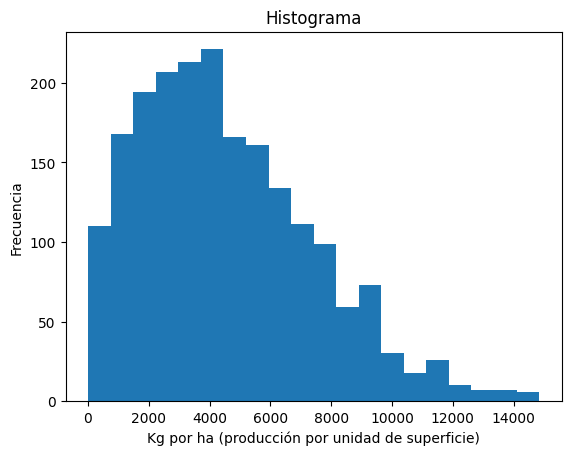

In [100]:
th = 15000
df_produccionxha = df_train_mod.loc[df_train_mod['Kgxha'] < th, ['Kgxha']]
plt.hist(df_produccionxha, bins=20)
plt.xlabel('Kg por ha (producción por unidad de superficie)')
plt.ylabel('Frecuencia')
plt.title('Histograma')
plt.show()

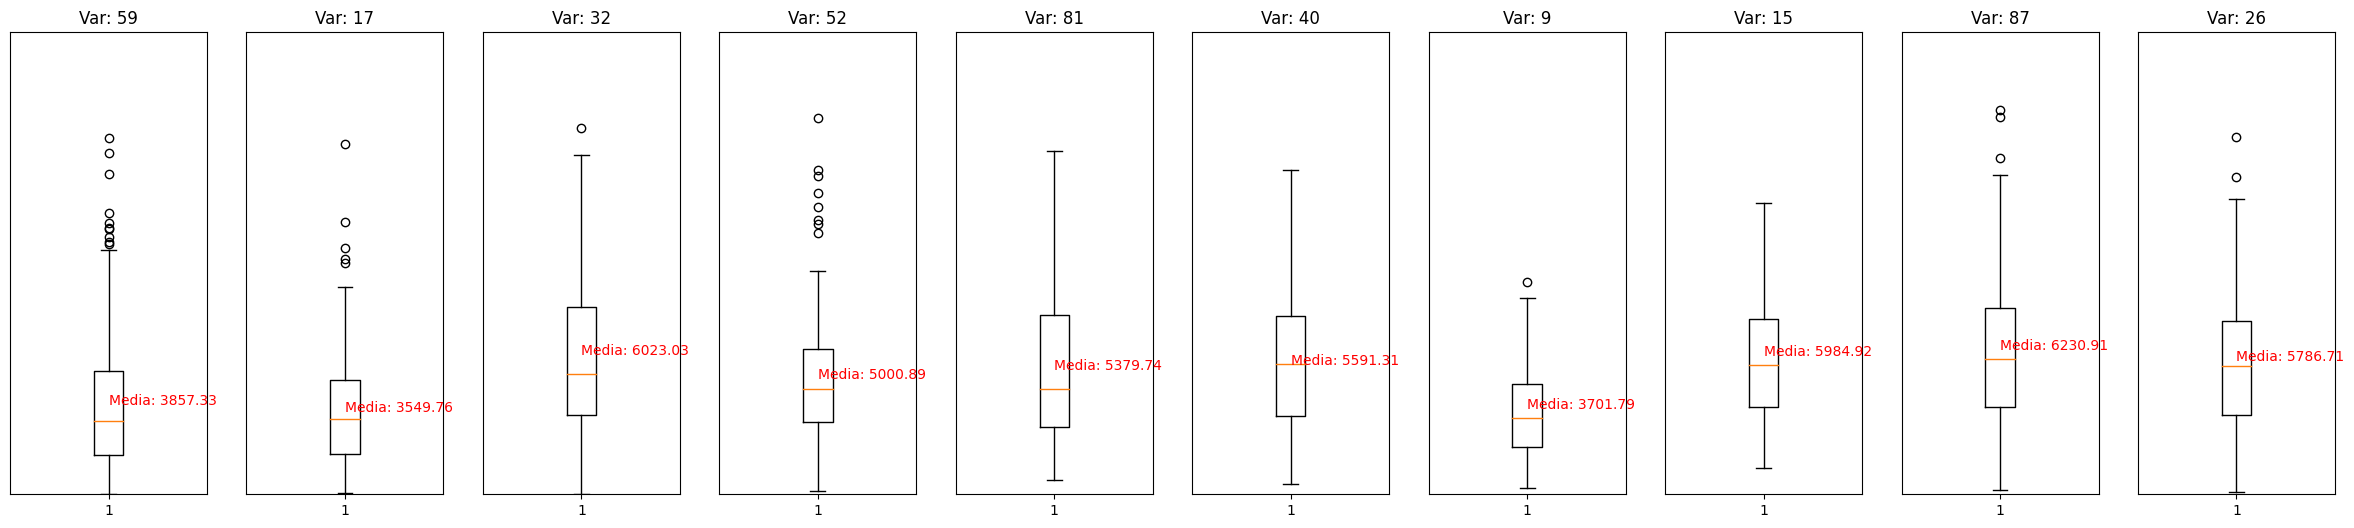

In [101]:
# variedad_top = [59, 17, 32, 52, 81, 40, 9, 15, 87, 26, 68, 94, 4, 23]
variedad_top = [59, 17, 32, 52, 81, 40, 9, 15, 87, 26]

plt.figure(figsize=(30, 6))

for i in range(len(variedad_top)):
    x = df_train_mod.loc[df_train_mod['VARIEDAD'] == variedad_top[i]]['Kgxha']
    media = x.mean()
    # graficar datos y regresión lineal
    plt.subplot(1, len(variedad_top), i+1)
    plt.boxplot(x)
    plt.title(f'Var: {variedad_top[i]}')
    plt.ylim(0, 20000)
    plt.yticks(ticks=[], labels=[])
    # plt.ylabel('Valor')
    plt.text(1, media, f'Media: {media:.2f}', fontsize=10, color='red')

# mostrar gráficas resultantes
# plt.tight_layout()
plt.show()

Cada uva tiene una media y una varianza de la produccion por ha bastante diferente, pero también hay bastante dispersión.

#### VARIEDAD, PRODUCCION POR ha Y MODO

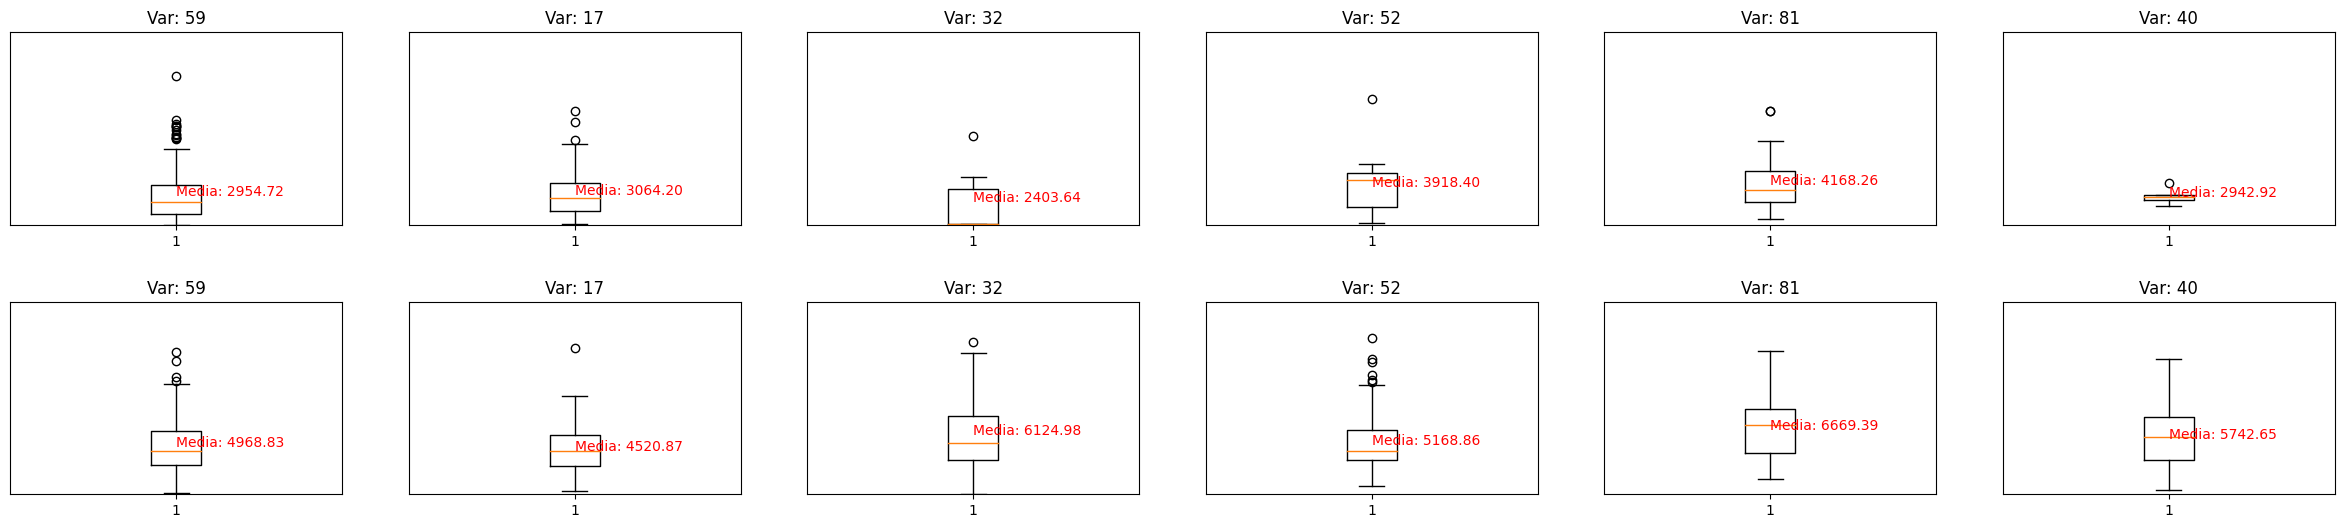

In [102]:
# Entender si hay uvas que dan mas produccion DEPENDIENDO DEL MODO (1 ó 2)
# variedad_top = [59, 17, 32, 52, 81, 40, 9, 15, 87, 26, 68, 94, 4, 23]
variedad_top = [59, 17, 32, 52, 81, 40]

plt.figure(figsize=(30, 6))

for i in range(len(variedad_top)):
    x = df_train_mod.loc[(df_train_mod['VARIEDAD'] == variedad_top[i]) & (df_train_mod['MODO'] == 1)]['Kgxha']
    media = x.mean()
    # graficar datos y regresión lineal
    plt.subplot(2, len(variedad_top), i+1)
    plt.boxplot(x)
    plt.title(f'Var: {variedad_top[i]}')
    plt.ylim(0, 20000)
    plt.yticks(ticks=[], labels=[])
    plt.text(1, media, f'Media: {media:.2f}', fontsize=10, color='red')

for i in range(len(variedad_top)):
    x = df_train_mod.loc[(df_train_mod['VARIEDAD'] == variedad_top[i]) & (df_train_mod['MODO'] == 2)]['Kgxha']
    media = x.mean()
    # graficar datos y regresión lineal
    plt.subplot(2, len(variedad_top), i+1+len(variedad_top))
    plt.boxplot(x)
    plt.title(f'Var: {variedad_top[i]}')
    plt.ylim(0, 20000)
    plt.yticks(ticks=[], labels=[])
    plt.text(1, media, f'Media: {media:.2f}', fontsize=10, color='red')

plt.subplots_adjust(hspace=0.4)
plt.show()

Se ven diferencias enormes en la media de la producción entre el modo de cultivo 1 y el 2. 

Web: 
* En promedio, los viñedos con sistema de espaldera pueden producir entre 10.000 y 20.000 kilos de uva por hectárea, mientras que los viñedos con sistema de vaso pueden producir entre 5.000 y 10.000 kilos de uva por hectárea.

Se mantienen las diferencias entre uvas.

#### IMPACTO DEL TIPO DE SUELO

In [103]:
df_train_mod.groupby('ID_ZONA')['CAMPAÑA'].count().describe()

count    106.000000
mean      19.141509
std       21.163058
min        1.000000
25%        4.000000
50%       11.500000
75%       27.750000
max      125.000000
Name: CAMPAÑA, dtype: float64

In [104]:
df_zona_prod = df_train_mod.groupby('ID_ZONA')['PRODUCCION'].sum()
df_zona_prod

ID_ZONA
7       53565.6090
36     176980.0000
41      77734.5220
44     116830.0000
47     388939.5920
          ...     
966     24780.0000
973     41917.1520
983    201523.5010
987     93375.9684
990     53020.0000
Name: PRODUCCION, Length: 106, dtype: float64

In [105]:
df_zona_superf = df_train_mod.groupby('ID_ZONA')['SUPERFICIE'].sum()
df_zona_superf

ID_ZONA
7       11.1316
36      50.9954
41      12.3000
44      31.9387
47     106.4212
         ...   
966      3.7000
973     10.0278
983     23.3848
987     15.2244
990     13.8743
Name: SUPERFICIE, Length: 106, dtype: float64

In [106]:
df_zon_Kgxha = df_zona_prod / df_zona_superf
df_zon_Kgxha

ID_ZONA
7      4812.031424
36     3470.509105
41     6319.879837
44     3657.944750
47     3654.719097
          ...     
966    6697.297297
973    4180.094537
983    8617.713258
987    6133.310239
990    3821.454055
Length: 106, dtype: float64

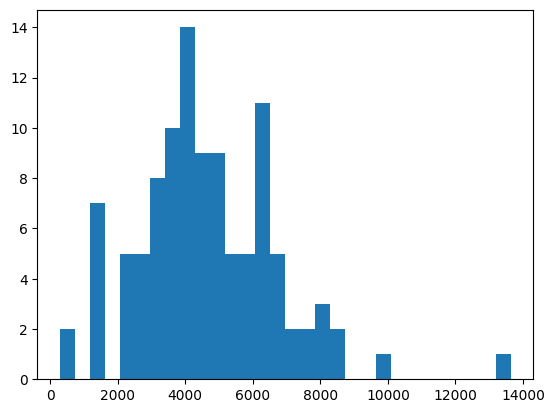

In [107]:
plt.hist(df_zon_Kgxha, bins=30)
plt.show()

In [108]:
# Parece que hay suelos con una media de produccion por ha muy baja y otros muy alta
# Vamos a analizar las zonas con alta produccion por ha
df_zon_Kgxha.loc[df_zon_Kgxha > 9000]

ID_ZONA
239     9788.820894
389    13638.712535
dtype: float64

In [109]:
zona_i = 239
df_train_mod.loc[df_train_mod['ID_ZONA'] == zona_i]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,Kgxha
7528,20,37461,239,6,700.0,52,2,0,1,3.680,28468.3,7735.951087
7529,20,58769,239,6,700.0,32,2,0,1,4.250,38480.0,9054.117647
7530,20,58769,239,6,700.0,59,2,0,1,4.160,39380.0,9466.346154
7531,20,88928,239,6,700.0,40,2,0,1,4.750,53060.0,11170.526316
7532,20,88928,239,6,700.0,52,2,0,1,1.462,14021.7,9590.766074
8582,21,37461,239,6,700.0,52,2,0,1,3.680,28160.1,7652.201087
8583,21,58769,239,6,700.0,32,2,0,1,4.250,41310.0,9720.000000
8584,21,58769,239,6,700.0,59,2,0,1,4.160,45420.0,10918.269231
8585,21,88928,239,6,700.0,40,2,0,1,4.750,56140.0,11818.947368
8586,21,88928,239,6,700.0,52,2,0,1,1.462,13869.9,9486.935705


In [110]:
zona_i = 389
df_train_mod.loc[df_train_mod['ID_ZONA'] == zona_i]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,Kgxha
7420,20,17977,389,9,470.0,92,1,0,0,1.3546,17690.0,13059.205670
8475,21,17977,389,9,470.0,92,1,0,0,1.3546,19260.0,14218.219401


In [111]:
# Vamos a analizar las zonas con baja produccion por ha
df_zon_Kgxha.loc[df_zon_Kgxha < 1000]


ID_ZONA
548    290.004133
559    592.592593
dtype: float64

In [112]:
zona_i = 548    
df_train_mod.loc[df_train_mod['ID_ZONA'] == zona_i]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,Kgxha
7535,21,28875,548,14,655.0,17,2,0,1,2.6616,771.875,290.004133


In [113]:
zona_i = 559    
df_train_mod.loc[df_train_mod['ID_ZONA'] == zona_i]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,Kgxha
6970,20,1885,559,19,700.0,59,1,0,1,3.24,1920.0,592.592593


El suelo parece influir en la producción. Variedades como la 17 tienen mucha variabilidad, con producciones muy bajas y muy altas.


#### Probar técnicas de reducción de la dimensionalidad

Si al hacer la PCA (Principal Component Analysis) de los datos se observa que se forman dos clusters que se separan por una cierta variable, esto sugiere que esa variable es importante para explicar las diferencias en la producción.

La PCA es una técnica no supervisada que ayuda a identificar patrones en los datos sin tener en cuenta la variable de respuesta o la variable que se quiere predecir. Por lo tanto, una vez que se identifican las variables importantes con la ayuda de la PCA, se debe utilizar técnicas de aprendizaje supervisado para desarrollar un modelo predictivo más preciso.

In [114]:
# Generamos el dataset df_train_subset datos: ['CAMPAÑA', 'ID_FINCA','VARIEDAD', 'COLOR', 'MODO', 'SUPERFICIE']
años_p = list(range(20,22))
df_train_subset = df_train.loc[df_train['CAMPAÑA'].isin(años_p),['CAMPAÑA', 'ID_FINCA','VARIEDAD', 'COLOR', 'MODO', 'SUPERFICIE']]
df_train_subset = df_train_subset.dropna()
df_train_subset.head(2)

,CAMPAÑA,ID_FINCA,VARIEDAD,COLOR,MODO,SUPERFICIE
6525,20,48626,32,1,2,3.7503
6526,20,47921,32,1,2,7.3735


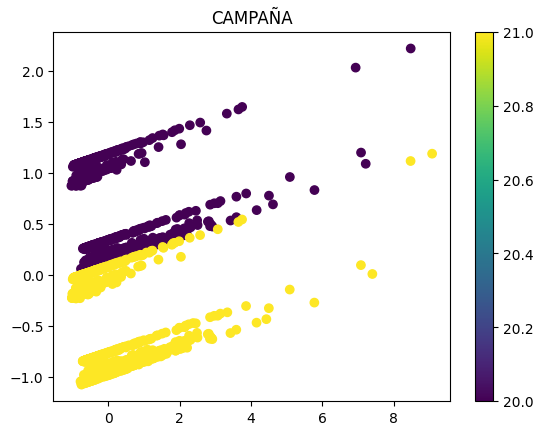

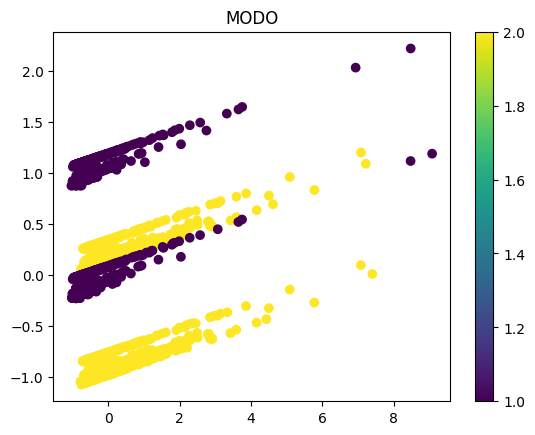

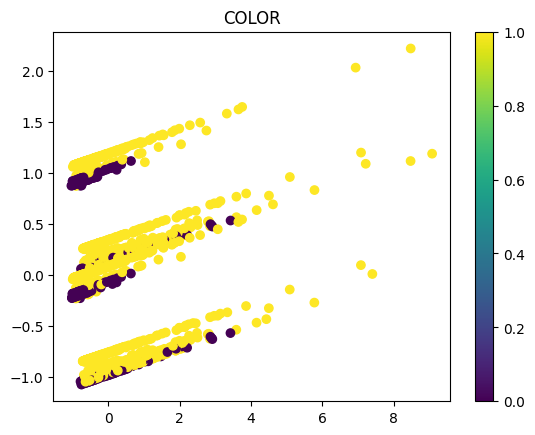

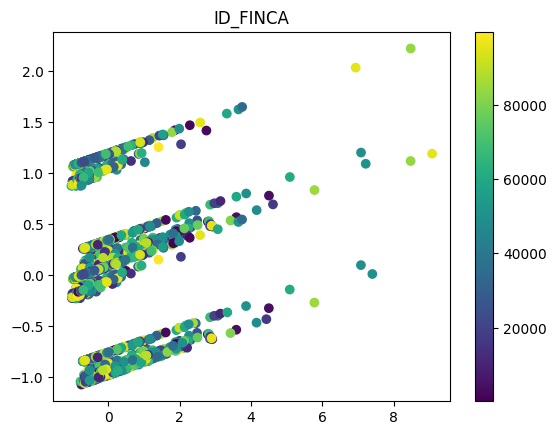

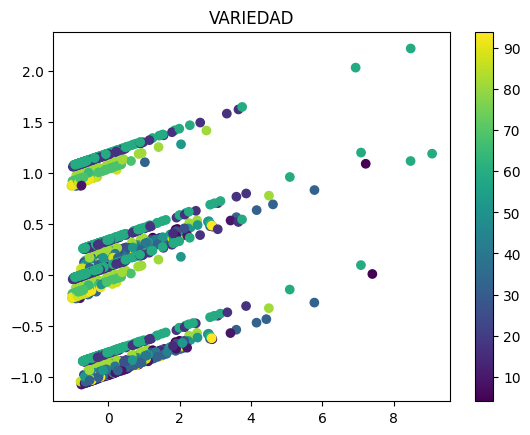

In [115]:
# PCA sobre el dataset
numeric_features = ['SUPERFICIE']
categorical_features = ['CAMPAÑA', 'ID_FINCA', 'VARIEDAD', 'COLOR',  'MODO'] 

encoder = OneHotEncoder()
encoded = encoder.fit_transform(df_train_subset[categorical_features]).toarray()
scaler = StandardScaler()
scaled = scaler.fit_transform(df_train_subset[numeric_features])

preprocessed_data = pd.concat([pd.DataFrame(scaled), pd.DataFrame(encoded)], axis=1)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(preprocessed_data)

# Representar por campaña
plt.title('CAMPAÑA')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=df_train_subset['CAMPAÑA'])
plt.colorbar()
plt.show()

# Representar por modo
plt.title('MODO')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=df_train_subset['MODO'])
plt.colorbar()
plt.show()

# Ahora lo mismo pero por color
plt.title('COLOR')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=df_train_subset['COLOR'])
plt.colorbar()
plt.show()

# Ahora lo mismo pero por numero de finca
plt.title('ID_FINCA')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=df_train_subset['ID_FINCA'])
plt.colorbar()
plt.show()

# Ahora lo mismo pero por variedad
plt.title('VARIEDAD')
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=df_train_subset['VARIEDAD'])
plt.colorbar()
plt.show()

Factores clave:
* La campaña (el año) influye enormemente (seguramente por el clima)
* El modo de cultivo influye enormemente (sabemos que espaldera tiene una mayor productividad)
* El color también parece tener un efecto
* La altitud también tiene efecto

## Carga de datos METEO y análisis

Web:

La producción de uvas y la calidad del vino están influenciados por muchos factores ambientales, incluyendo la temperatura, la humedad, la precipitación, la cantidad de luz solar y la calidad del suelo. 

### Carga de datos TRAIN y análisis

In [211]:
file = 'DATOS_METEO.txt'
df_meteo = pd.read_csv(file, sep="|")
print(df_meteo.shape)
df_meteo.head(5)

(1223660, 33)


,validTimeUtc,precip1Hour,precip6Hour,precip24Hour,precip2Day,precip3Day,precip7Day,precipMtd,precipYtd,pressureChange,...,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION
0,2015-06-29 16:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.4,...,36.3,17.9,12.8,34.5,2.0,16.09,NaN,NaN,18.7,13
1,2015-06-29 17:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,35.0,17.9,12.3,34.3,1.0,16.09,NaN,NaN,18.0,13
2,2015-06-29 18:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.3,...,34.7,17.9,12.4,32.8,0.0,16.09,NaN,NaN,16.6,13
3,2015-06-29 19:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.3,...,34.7,17.9,12.9,31.0,0.0,16.09,NaN,NaN,15.1,13
4,2015-06-29 20:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.9,...,34.7,17.9,13.9,28.0,0.0,16.09,NaN,NaN,10.1,13


In [212]:
# 0 validTimeUtc
#  1 precip1Hour:            volumen de lluvia en la última hora 
#  2 precip6Hour:            volumen de lluvia en las últimas 6 horas
#  3 precip24Hour:           volumen de lluvia en las últimas 24 horas 
#  4 precip2Day:             volumen de lluvia en los últimos 2 días
#  5 precip3Day:             volumen de lluvia en los últimos 3 días 
#  6 precip7Day:             volumen de lluvia en los últimos 7 días
#  7 precipMtd:              Volumen de lluvia en el mes en curso 
#  8 precipYtd:              Volumen de lluvia en el año en curso
#  9 pressureChange:         Variación máxima en la presión atmosférica en las últimas 3 horas 
# 10 pressureMeanSeaLevel:  Diferencia barométrica respecto al nivel del mar
# 11 relativeHumidity:       humedad relativa
# 12 snow1Hour:              volumen de nieve en la última hora
# 13 snow6Hour:              volumen de nieve en las últimas 6 horas 
# 14 snow24Hour:             volumen de nieve en las últimas 24 horas
# 15 snow2Day:               volumen de nieve en los últimos 2 días 
# 16 snow3Day:               volumen de nieve en los últimos 3 días
# 17 snow7Day:               volumen de nieve en los últimos 7 días 
# 18 snowMtd:                volumen de nieve en el mes en curso
# 19 snowSeason:             volumen de nieve trimestral (DIC-FEB, MAR-MAY, JUN-AGO, SEP-NOV) 
# 20 snowYtd:                volumen de nieve en el año en curso
# 21 temperature:            Temperatura ambiente a 2 metros del suelo 
# 22 temperatureChange24Hour:variación de temperatura respecto al día anterior
# 23 temperatureMax24Hour:   temperatura máxima últimas 24 horas 
# 24 temperatureMin24Hour:   temperatura mínima últimas 24 horas
# 25 temperatureDewPoint:    Punto de rocío, temperatura a la cual el aire debe ser enfriado a presión constante para alcanzar la saturación. El punto de rocío es también una medida indirecta de la humedad del aire. 
# 26 temperatureFeelsLike:   Sensación térmica. Temperatura aparente resultante de combinación de la temperatura, la humedad y la velocidad del viento.
# 27 uvIndex:                radiación ultravioleta categorizada: -2, -1= No disponible / 0-2 = baja / 3-5 = moderada / 6-7 = alta / 8-10 = muy alta / 11-16 = extrema 
# 28 visibility:             Visibilidad horizontal desde la estación meteorológica, 999 equivale a ilimitada
# 29 windDirection:          Dirección del viento en grados 0 – Norte, 90 – Este, 180 – Sur, 270 – Oeste 
# 30 windGust:               velocidad máxima de ráfaga de viento registrada durante el período de observación
# 31 windSpeed:              fuerza del viento 
# 32 ID_ESTACION:            Identificador de la estación meteorológica

In [213]:
# Elegir un subset de parámetros que parecen tener sentido para el problema
columns_l = df_meteo.columns
# if elem == 'rain': columnas_add.append('precip1Hour')
# elif elem == 'Tmax': columnas_add.append('temperatureMax24Hour')
# elif elem == 'Tmin': columnas_add.append('temperatureMin24Hour')
# elif elem == 'TDew': columnas_add.append('temperatureDewPoint')
# elif elem == 'snow': columnas_add.append('snow1Hour')
# elif elem == 'Humidity': columnas_add.append('relativeHumidity')
# elif elem == 'uvIndex': columnas_add.append('uvIndex')
# elif elem == 'visibility': columnas_add.append('visibility')
# elif elem == 'presion': columnas_add.append('pressureMeanSeaLevel')
# elif elem == 'Tavg': columnas_add.append('temperature')
indices = [0, 1, 12, 21, 27, 32]
df_meteo = df_meteo[columns_l[indices]]
df_meteo.head(3)

,validTimeUtc,precip1Hour,snow1Hour,temperature,uvIndex,ID_ESTACION
0,2015-06-29 16:20:00,0.0,0.0,34.5,2.0,13
1,2015-06-29 17:20:00,0.0,0.0,34.3,1.0,13
2,2015-06-29 18:20:00,0.0,0.0,32.8,0.0,13


In [214]:
# Elegir un subset de fechas: campañas 2016-2022 (suposicion: la campaña 2016 empieza tras la vendimia de 2015)
df_meteo['validTimeUtc'] = pd.to_datetime(df_meteo['validTimeUtc'])
df_meteo = df_meteo.loc[df_meteo['validTimeUtc'] >= '2016-01-01']
df_meteo.head(2)

,validTimeUtc,precip1Hour,snow1Hour,temperature,uvIndex,ID_ESTACION
4388,2016-01-01 00:20:00,0.0,0.0,9.4,0.0,13
4389,2016-01-01 01:20:00,0.0,0.0,9.2,0.0,13


### Tipos de datos y NaN

In [215]:
df_meteo.describe()

,validTimeUtc,precip1Hour,snow1Hour,temperature,uvIndex,ID_ESTACION
count,1135900,1.135880e+06,1.135880e+06,1.135880e+06,1.135880e+06,1.135900e+06
mean,2019-04-03 10:14:48.014790656,6.482762e-02,7.969152e-04,1.523417e+01,1.357696e+00,9.500000e+00
min,2016-01-01 00:20:00,0.000000e+00,0.000000e+00,-7.900000e+00,0.000000e+00,0.000000e+00
25%,2017-08-19 05:20:00,0.000000e+00,0.000000e+00,9.200000e+00,0.000000e+00,4.750000e+00
50%,2019-04-04 01:20:00,0.000000e+00,0.000000e+00,1.440000e+01,0.000000e+00,9.500000e+00
75%,2020-11-16 02:20:00,0.000000e+00,0.000000e+00,2.070000e+01,2.000000e+00,1.425000e+01
max,2022-06-30 23:20:00,6.030000e+01,5.000000e+00,4.320000e+01,1.000000e+01,1.900000e+01
std,NaN,5.311995e-01,3.654006e-02,7.975273e+00,2.355252e+00,5.766284e+00


In [216]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1135900 entries, 4388 to 1223659
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   validTimeUtc  1135900 non-null  datetime64[ns]
 1   precip1Hour   1135880 non-null  float64       
 2   snow1Hour     1135880 non-null  float64       
 3   temperature   1135880 non-null  float64       
 4   uvIndex       1135880 non-null  float64       
 5   ID_ESTACION   1135900 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 60.7 MB


In [217]:
# Todos los NaN estan acumulados en un dia y una hora, para las 20 estaciones
# Cuando se consoliden datos, desapareceran
# df_meteo[df_meteo['precip1Hour'].isna()]

In [218]:
# Agrupar los datos con escala diaria
columns_agg = {}
columns_agg['precip1Hour'] = 'sum'
columns_agg['snow1Hour'] = 'sum'
columns_agg['temperature'] = 'max'
columns_agg['uvIndex'] = 'max'
df_meteo = df_meteo.groupby([pd.Grouper(key='validTimeUtc', freq='D'),'ID_ESTACION']).agg(columns_agg)

In [219]:
df_meteo = df_meteo.reset_index()

In [220]:
# Agrupar los datos con escala mensual
columns_agg = {}
columns_agg['precip1Hour'] = 'sum'
columns_agg['snow1Hour'] = 'sum'
columns_agg['temperature'] = 'mean'
columns_agg['uvIndex'] = 'max'
df_meteo = df_meteo.groupby([pd.Grouper(key='validTimeUtc', freq='M'),'ID_ESTACION']).agg(columns_agg)

In [221]:
df_meteo = df_meteo.reset_index()

In [222]:
# Renombrar columnas   
df_meteo.columns = ['validTimeUtc', 'ID_ESTACION', 'precip_cum', 'snow_cum', 'temperature_max_mean', 'uvIndex_max'] 
df_meteo['month'] = df_meteo['validTimeUtc'].dt.strftime('%m')
df_meteo['CAMPAÑA'] = df_meteo['validTimeUtc'].dt.strftime('%y')

In [223]:
df_meteo = df_meteo.drop('validTimeUtc', axis=1)

In [224]:
df_meteo = df_meteo[~df_meteo['month'].isin(['07', '08', '09', '10', '11', '12'])]

In [225]:
# Utilizar la función pivot_table para transformar el DataFrame
df_meteo = pd.pivot_table(df_meteo, index=['ID_ESTACION', 'CAMPAÑA'], columns=['month'], values=['precip_cum', 'snow_cum', 'temperature_max_mean', 'uvIndex_max'])
# Restablecer los nombres de las columnas
df_meteo.columns = [f'{col}_{month}' for col, month in df_meteo.columns]
# Restablecer el índice
df_meteo = df_meteo.reset_index()


In [226]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_ESTACION              140 non-null    int64  
 1   CAMPAÑA                  140 non-null    object 
 2   precip_cum_01            140 non-null    float64
 3   precip_cum_02            140 non-null    float64
 4   precip_cum_03            140 non-null    float64
 5   precip_cum_04            140 non-null    float64
 6   precip_cum_05            140 non-null    float64
 7   precip_cum_06            140 non-null    float64
 8   snow_cum_01              140 non-null    float64
 9   snow_cum_02              140 non-null    float64
 10  snow_cum_03              140 non-null    float64
 11  snow_cum_04              140 non-null    float64
 12  snow_cum_05              140 non-null    float64
 13  snow_cum_06              140 non-null    float64
 14  temperature_max_mean_01  1

In [227]:
df_meteo.head(2)

,ID_ESTACION,CAMPAÑA,precip_cum_01,precip_cum_02,precip_cum_03,precip_cum_04,precip_cum_05,precip_cum_06,snow_cum_01,snow_cum_02,...,temperature_max_mean_03,temperature_max_mean_04,temperature_max_mean_05,temperature_max_mean_06,uvIndex_max_01,uvIndex_max_02,uvIndex_max_03,uvIndex_max_04,uvIndex_max_05,uvIndex_max_06
0,0,16,15.5,12.2,29.9,136.9,35.1,3.6,0.0,0.0,...,16.416129,19.043333,23.219355,29.476667,3.0,4.0,6.0,8.0,9.0,9.0
1,0,17,192.4,13.2,170.3,57.5,2.2,21.1,12.4,0.0,...,18.012903,19.386667,24.325806,29.946667,3.0,4.0,6.0,8.0,9.0,9.0


In [228]:
# Guardar el archivo modificado
df_meteo.to_csv('DATOS_METEO_MES.txt', index=False, sep='|')

Resumen:
* En las fechas 2016-2022 solo habia una hora con datos NaN para las columnas escogidas
* Como se agrupan con escala diaria, estos NaN no tienen mucha importancia
* Luego se agrupan por mes, ya que sabemos que en distintos momentos de la planta tendra mas importancia una cosa u otra (luz, lluvia...)